# Local RAG Evaluation with syftr

This notebook demonstrates how to run a syftr evaluation study using local documents and QA pairs, without downloading datasets from HuggingFace.

We assume:
- You have already placed your local QA CSV and grounding documents under `data/local_data/`.
- Your study config YAML (e.g. `my-docs.yaml`) is already defined to use `xname: my_dataset`.


In [1]:
!cat ../studies/my-docs.yaml

dataset:
  xname: my_dataset
name: my-docs
optimization:
  cpus_per_trial: 1
  max_concurrent_trials: 10
  num_eval_batch: 5
  num_eval_samples: 10
  num_trials: 30
recreate_study: true
reuse_study: false
search_space:
  additional_context_enabled:
    - false
    - true
  few_shot_enabled:
  - false
  hyde_enabled:
  - false
  - true
  hyde:
    llms:
    - gpt-4o-mini
  rag_modes:
  - no_rag
  - rag
  - react_rag_agent
  - critique_rag_agent
  - sub_question_rag
  - lats_rag_agent"
  rag_retriever:
    embedding_models:
    - BAAI/bge-small-en-v1.5
    - BAAI/bge-large-en-v1.5
    - sentence-transformers/all-MiniLM-L12-v2
    methods:
    - dense
    - sparse
    - hybrid
    query_decomposition_enabled:
    - false
    - true
    top_k:
      kmax: 50
      kmin: 2
      log: false
      step: 1
  reranker_enabled:
  - true
  reranker:
    llms:
    - gpt-4o-mini
  response_synthesizer_llms:
  - gpt-4o-mini
  - gpt-35-turbo
  - gpt-4o-std
  react_rag_agent:
    subquestion_engine_ll

## Input Data Preparation

Before running the study, ensure that your local input files are placed correctly under the `data/local_data/` directory in your repository.

### 1. `custom_qa_data.csv`

This CSV file must contain the QA pairs to evaluate. It must have the following columns:

- `id`: Unique identifier for each question
- `question`: The question to be asked
- `answer`: The expected answer (used to compute accuracy)

Example row from `custom_qa_data.csv`:

| id  | question                      | answer          |
|-----|-------------------------------|-----------------|
| 1   | What is the capital of Japan? | Tokyo           |

> This file should be located at: `data/local_data/custom_qa_data.csv`

---

### 2. `grounding_docs/` directory

This directory should contain one or more document files (e.g., Markdown `.md`, `.txt`, etc.) to be used as grounding context for the RAG pipeline.

> The directory path should be: `data/local_data/grounding_docs/`

Each file will be parsed into text chunks using `llama_index` and indexed for retrieval.

If this directory is missing or empty, the RAG system will fail to retrieve grounding information.


## Ray Initialization

We initialize Ray explicitly. If you're re-running this notebook multiple times (e.g., for iterative experiments), we recommend shutting down any previous Ray sessions to avoid port conflicts or zombie processes.


In [2]:
import ray

# Stop Ray if it's already running (safe for repeated runs)
try:
    ray.shutdown()
    print("Ray shutdown completed.")
except Exception as e:
    print(f"Failed to shutdown Ray: {e}")

# Initialize Ray
ray.init()
print("Ray initialized.")


Ray shutdown completed.


2025-08-04 14:37:12,922	INFO worker.py:1879 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Ray initialized.


## Copy Local Data into Ray Worker-Visible Path

Ray workers operate in a temporary runtime environment and cannot access your original `data/local_data/` directly.

Therefore, we copy required local files (QA CSV and grounding docs) into Ray's temporary working directory (usually `/tmp/ray/data/local_data`) before running the study.


In [3]:
import shutil
from pathlib import Path
from ray._private.utils import get_ray_temp_dir

from syftr.configuration import cfg

def copy_local_data_to_ray_tmp():
    """
    Copy local_data directory to Ray's temp directory.
    Must be called before ray.init().
    """
    qa_csv = "custom_qa_data.csv"
    grounding_data_dir = "grounding_docs"
    
    ray_data_dir = Path(get_ray_temp_dir()) / "data" / "local_data"
    ray_data_dir.mkdir(parents=True, exist_ok=True)

    local_data_dir = cfg.paths.local_data_dir.resolve()
    qa_src = local_data_dir / qa_csv
    grounding_src = local_data_dir / grounding_data_dir

    qa_dst = ray_data_dir / qa_csv
    grounding_dst = ray_data_dir / grounding_data_dir

    if not qa_dst.exists():
        shutil.copy(qa_src, qa_dst)
        print(f"Copied QA data to {qa_dst}")
    else:
        print(f"QA data already exists at {qa_dst}")

    if not grounding_dst.exists():
        shutil.copytree(grounding_src, grounding_dst, dirs_exist_ok=True)
        print(f"Copied grounding docs to {grounding_dst}")
    else:
        print(f"Grounding docs already exist at {grounding_dst}")


In [4]:
copy_local_data_to_ray_tmp()

QA data already exists at /tmp/ray/data/local_data/custom_qa_data.csv
Grounding docs already exist at /tmp/ray/data/local_data/grounding_docs


## Run the Evaluation Study

We now load the study definition from our YAML configuration file (`my-docs.yaml`) and execute it using syftr.

The study will run multiple evaluation flows in parallel using Ray. Each flow corresponds to a different combination of RAG or non-RAG parameters (e.g., with/without few-shot, different retrieval strategies, etc.).

After submitting the study with `.run()`, we `await` its completion using `.wait_for_completion()` before moving on to result inspection.

This may take several minutes depending on the number of flows and model latency.


In [5]:
from syftr import api

example_study = api.Study.from_file(cfg.paths.studies_dir / "my-docs.yaml")
example_study

Study(name=my-docs, remote=False)

In [6]:
example_study.run()

[I 2025-08-04 14:37:20,226] Connecting to Ray job submission client at `http://127.0.0.1:8265`
INFO:syftr:Connecting to Ray job submission client at `http://127.0.0.1:8265`
[W 2025-08-04 14:37:20,236] Using existing ray client with address 'None'
[I 2025-08-04 14:37:20,297] Submitting job to local Ray instance
INFO:syftr:Submitting job to local Ray instance
2025-08-04 14:37:20,303	INFO dashboard_sdk.py:338 -- Uploading package gcs://_ray_pkg_d474bc6438db16e8.zip.
2025-08-04 14:37:20,304	INFO packaging.py:576 -- Creating a file package for local module '/Users/kento.okubo/Desktop/syftr_demo/syftr/ray_working_dir'.
2025-08-04 14:37:20,341	INFO dashboard_sdk.py:338 -- Uploading package gcs://_ray_pkg_ffc2b8c75dff9c10.zip.
2025-08-04 14:37:20,341	INFO packaging.py:576 -- Creating a file package for local module '/Users/kento.okubo/Desktop/syftr_demo/syftr/syftr'.
[I 2025-08-04 14:37:20,461] Job started at: http://127.0.0.1:8265/#/jobs/2025-08-04-05:37:20--kento.okubo--my-docs--6bfc216
INFO

In [7]:
await example_study.wait_for_completion()

## Post-Evaluation Summary

After the study completes, we can inspect each flow (trial) to understand how different RAG parameters impacted cost and accuracy.


In [8]:
from pprint import pprint

for i, flow in enumerate(example_study.pareto_flows):
    print(f"\n Pareto Flow # {i+1}:")
    pprint(flow)

[I 2025-08-04 14:48:57,282] Loaded 20 trials
INFO:syftr:Loaded 20 trials



 Pareto Flow # 1:
{'metrics': {'accuracy': 1.0, 'llm_cost_mean': 3.922499999999999e-05},
 'params': {'rag_mode': 'no_rag',
            'response_synthesizer_llm': 'gpt-4o-mini',
            'template_name': 'concise'}}


In [9]:
flows_df = example_study.flows_df

[I 2025-08-04 14:48:59,415] Loaded 20 trials
INFO:syftr:Loaded 20 trials


In [10]:
for col in flows_df.columns:
    print(col)

number
values_0
values_1
datetime_start
datetime_complete
duration
params_additional_context_enabled
params_additional_context_num_nodes
params_critique_agent_llm
params_few_shot_enabled
params_hyde_enabled
params_hyde_llm_name
params_max_iterations
params_rag_embedding_model
params_rag_fusion_mode
params_rag_hybrid_bm25_weight
params_rag_method
params_rag_mode
params_rag_query_decomposition_enabled
params_rag_query_decomposition_llm_name
params_rag_query_decomposition_num_queries
params_rag_top_k
params_reflection_agent_llm
params_reranker_enabled
params_reranker_llm_name
params_reranker_top_k
params_response_synthesizer_llm
params_splitter_chunk_exp
params_splitter_chunk_overlap_frac
params_splitter_method
params_subquestion_engine_llm
params_subquestion_response_synthesizer_llm
params_template_name
user_attrs_block_name
user_attrs_dataset
user_attrs_flow
user_attrs_flow_name
user_attrs_is_seeding
user_attrs_metric_acc_confidence
user_attrs_metric_accuracy
user_attrs_metric_cardinali

In [11]:
flows_df.rename(columns={"values_0": "Accuracy", "values_1": "Cost"},).head()

,number,Accuracy,Cost,datetime_start,datetime_complete,duration,params_additional_context_enabled,params_additional_context_num_nodes,params_critique_agent_llm,params_few_shot_enabled,...,user_attrs_metric_passing_std,user_attrs_metric_prune_reason,user_attrs_metric_run_times_p80_std,user_attrs_metric_run_times_std,user_attrs_metric_total_qa_pairs,user_attrs_ray_worker_hostname,user_attrs_ray_worker_pid,system_attrs_nsga2:generation,state,study_name
0,0,0.9,0.000154,2025-08-04 14:40:28.281087,2025-08-04 14:40:28.281087,0 days,NaN,NaN,NaN,NaN,...,0.3,NaN,0.414990,0.514588,10.0,kokubo-mb-2RNQ6,69226.0,NaN,COMPLETE,my-docs
1,1,0.9,0.000109,2025-08-04 14:40:29.291728,2025-08-04 14:40:29.291728,0 days,NaN,NaN,NaN,NaN,...,0.3,NaN,0.276537,0.352887,10.0,kokubo-mb-2RNQ6,69227.0,NaN,COMPLETE,my-docs
2,2,0.9,0.000565,2025-08-04 14:41:27.764939,2025-08-04 14:41:27.764939,0 days,NaN,NaN,NaN,NaN,...,0.3,NaN,0.272292,0.364289,10.0,kokubo-mb-2RNQ6,69233.0,NaN,COMPLETE,my-docs
3,3,1.0,0.000079,2025-08-04 14:41:27.852444,2025-08-04 14:41:27.852444,0 days,NaN,NaN,NaN,NaN,...,0.0,NaN,0.677403,1.372199,10.0,kokubo-mb-2RNQ6,69226.0,NaN,COMPLETE,my-docs
4,4,1.0,0.000276,2025-08-04 14:41:28.128093,2025-08-04 14:41:28.128093,0 days,NaN,NaN,NaN,NaN,...,0.0,NaN,0.349852,0.412417,10.0,kokubo-mb-2RNQ6,69230.0,NaN,COMPLETE,my-docs


Loading Studies: 100%|██████████| 1/1 [00:00<00:00, 74.00it/s]


data has 39 rows

Running: create_study_stats_table
Running: create_exceptions_stats_table
Running: pareto_plot_and_table
data has 25 rows
Running: generate_trial_description_table
data has 1 rows
data has 25 rows
Found no baselines for parameters: {'params_response_synthesizer_llm': 'gemini-flash', 'params_rag_mode': 'rag', 'params_template_name': 'default', 'params_splitter_method': 'sentence', 'params_splitter_chunk_exp': 10, 'params_splitter_chunk_overlap_frac': 0.25, 'params_rag_method': 'sparse', 'params_rag_top_k': 50, 'params_rag_query_decomposition_enabled': False, 'params_reranker_enabled': False, 'params_hyde_enabled': False, 'params_additional_context_enabled': False}
Running: style_pareto_table


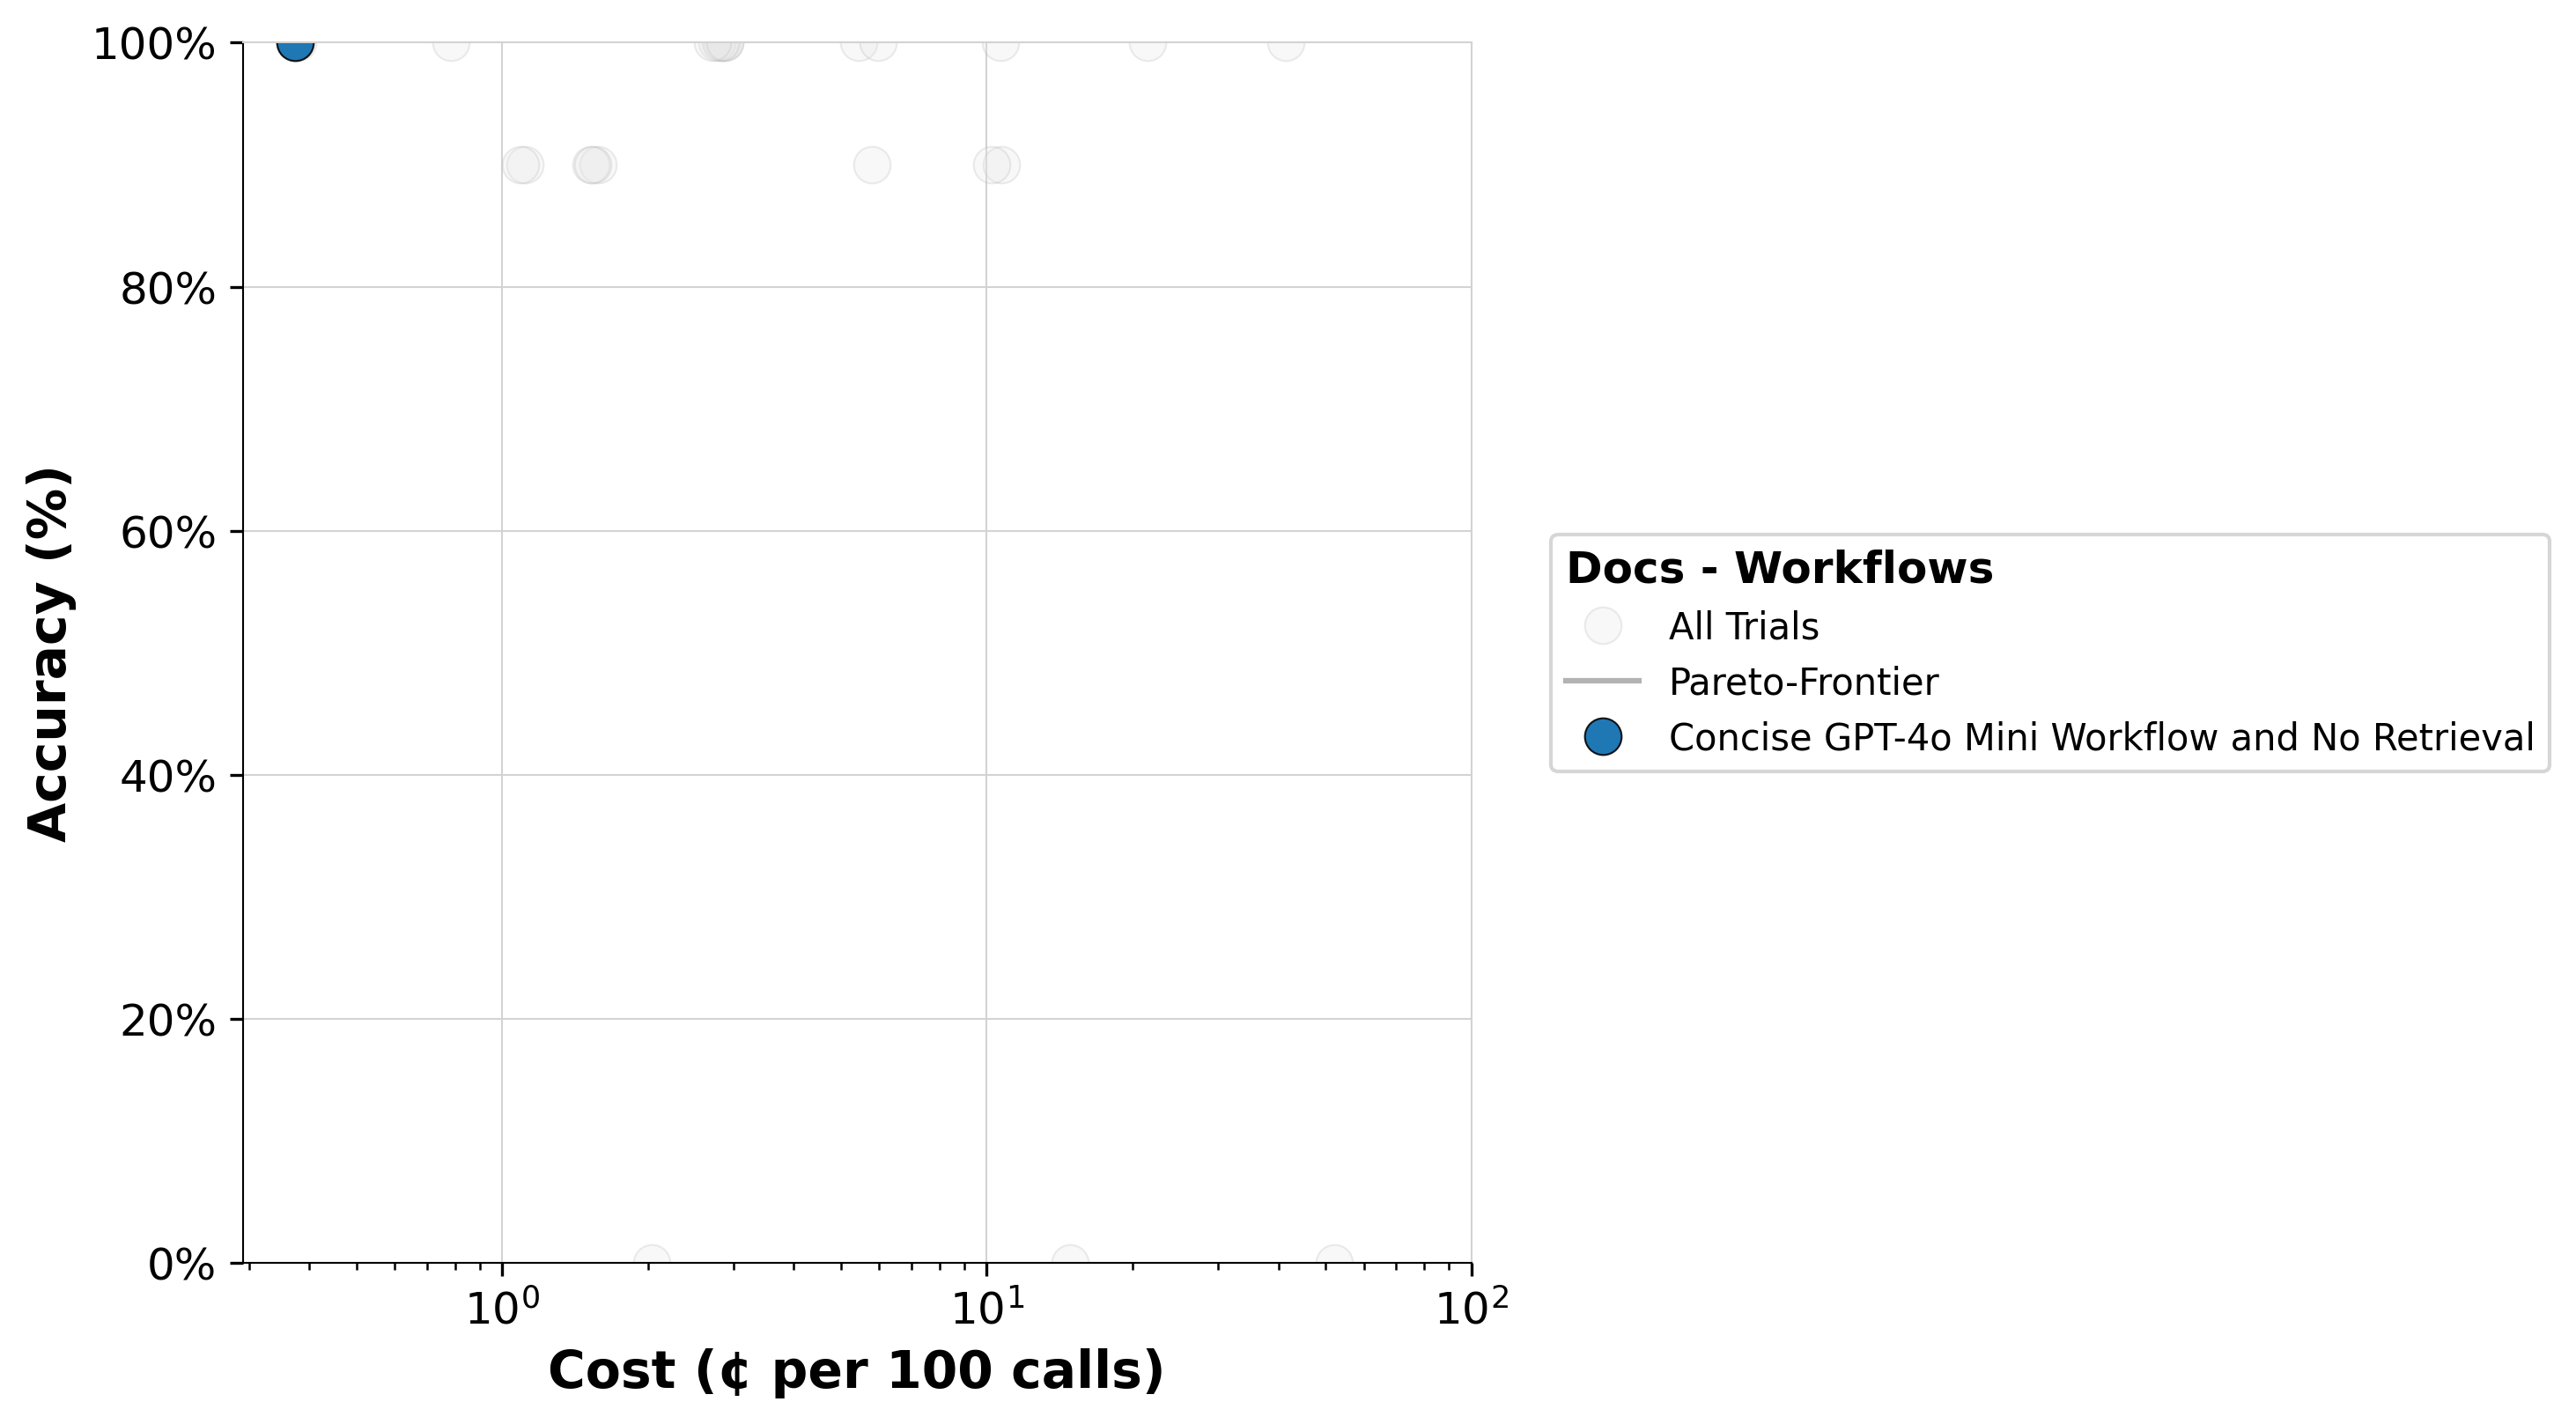

In [12]:
example_study.plot_pareto()

### Accuracy Distribution

Visualizes the distribution of accuracy across all evaluation flows in the study.


Running: accuracy_plot


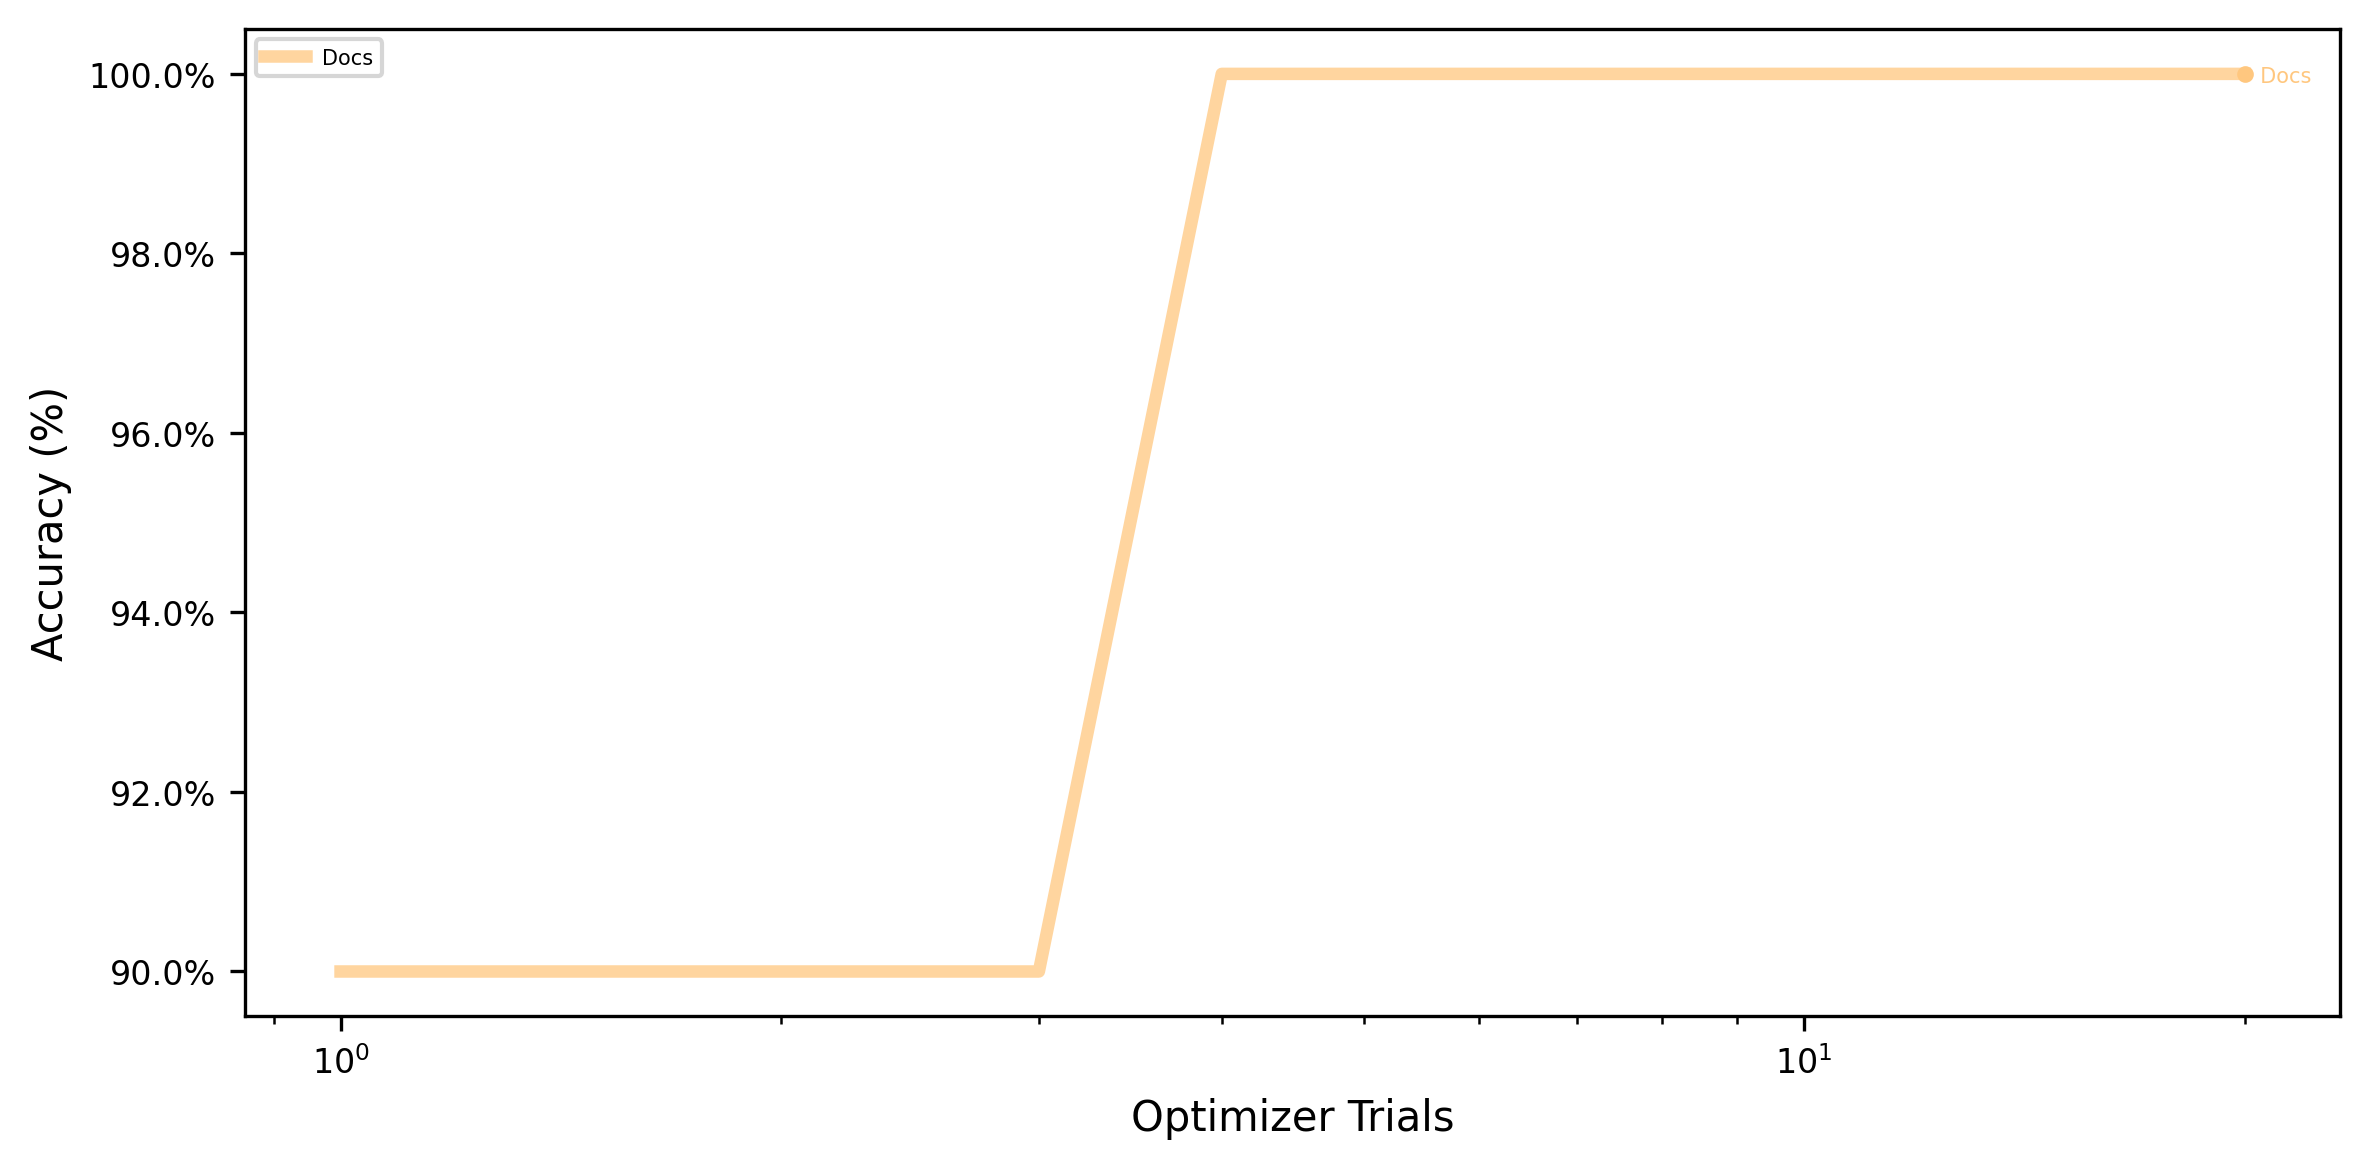

In [13]:
from syftr.plotting.insights import accuracy_plot
_ = accuracy_plot(flows_df, study_name="my-docs")

### LLM Cost Distribution

Shows the distribution of average LLM cost per flow to understand budget efficiency.


Running: cost_plot


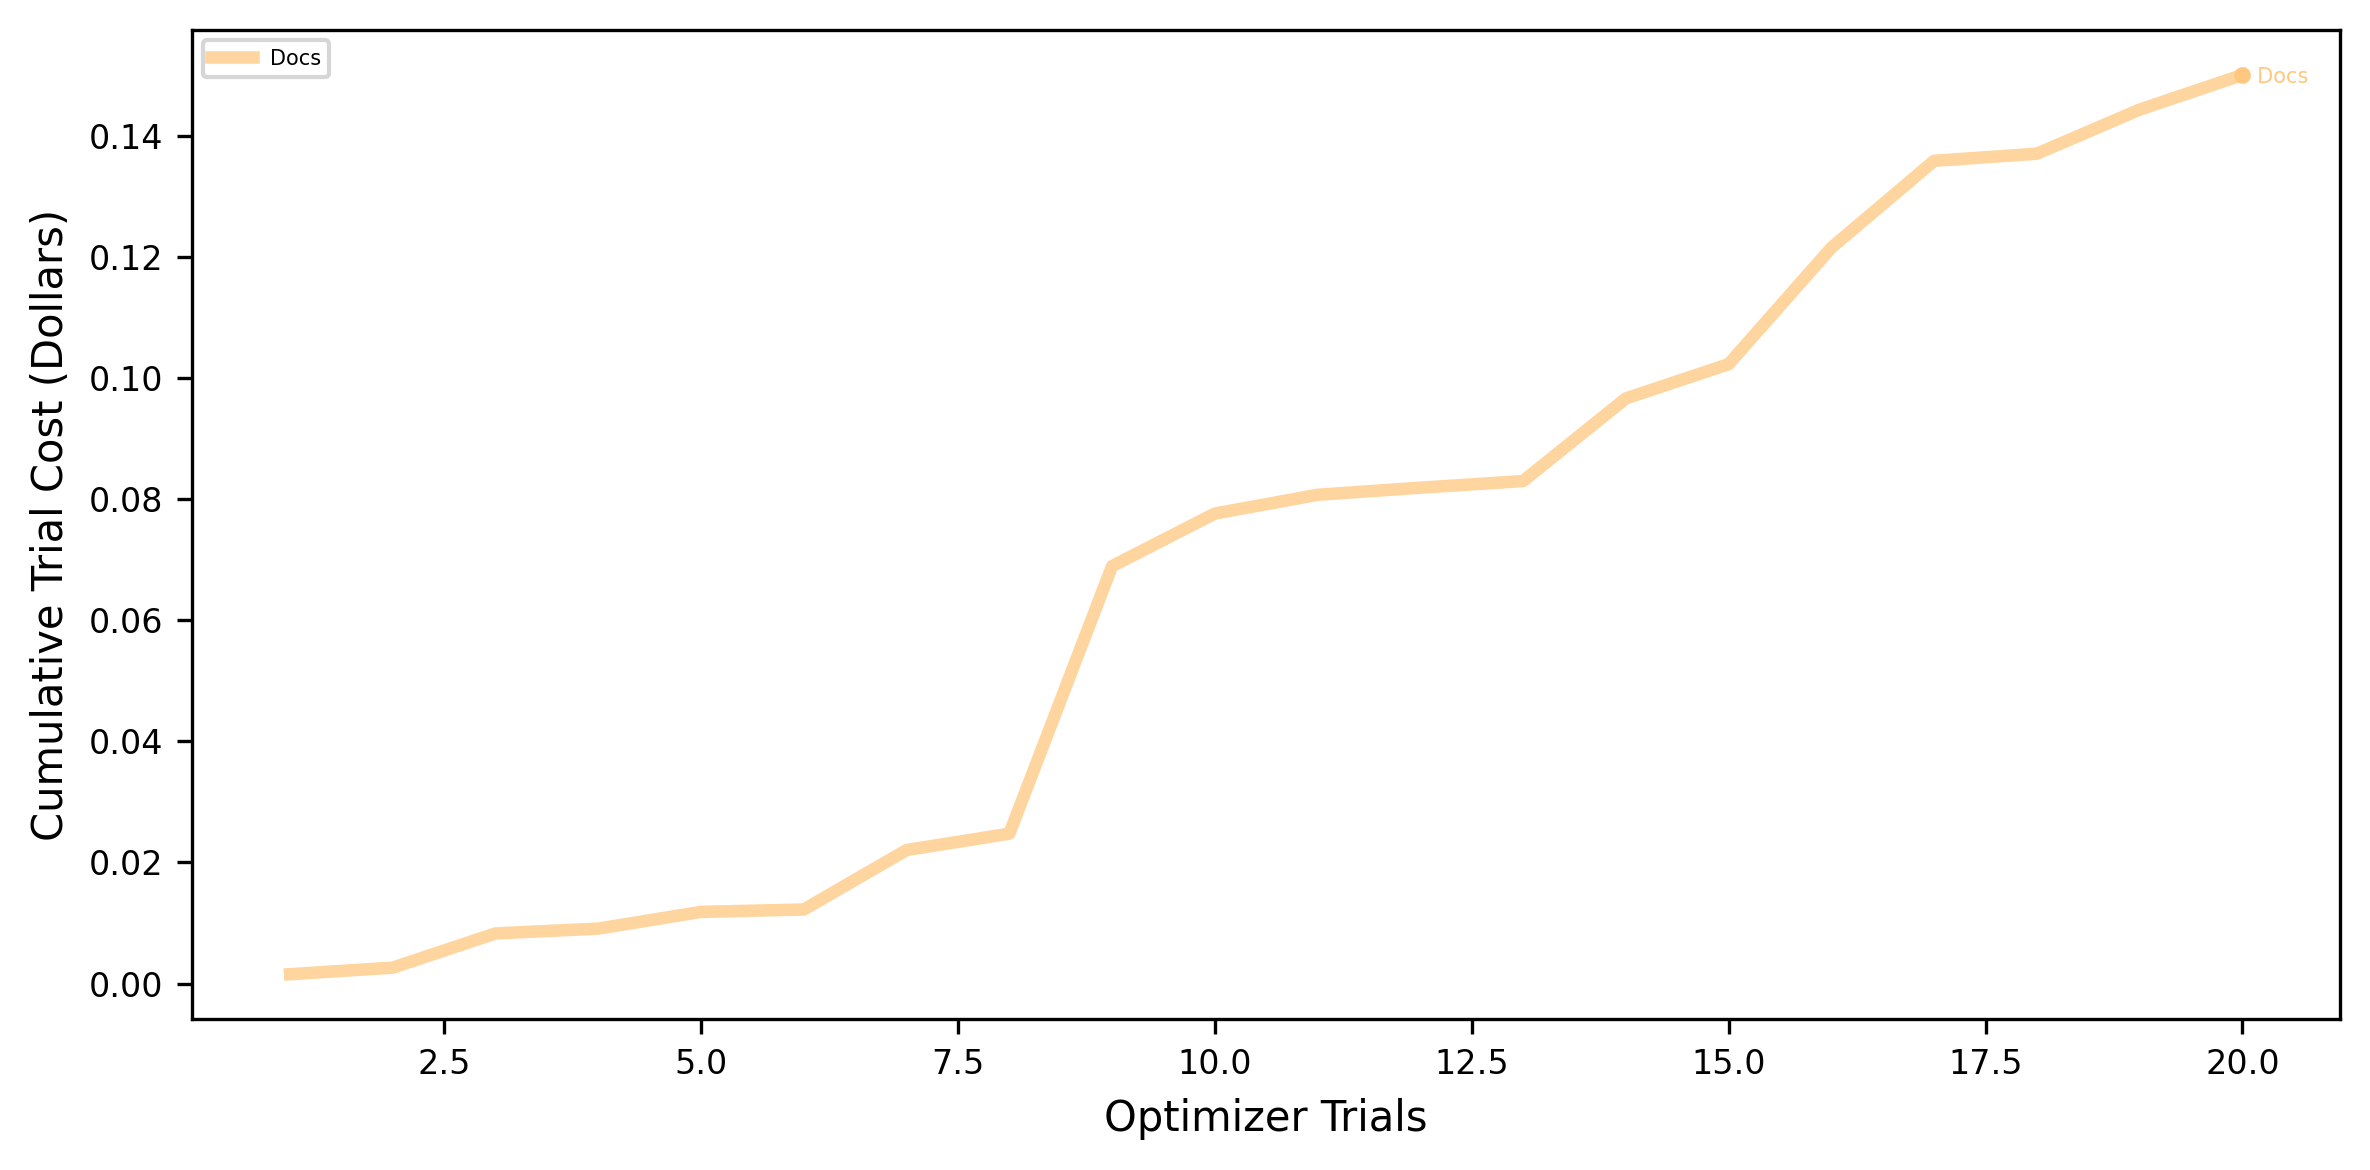

In [14]:
from syftr.plotting.insights import cost_plot
_ = cost_plot(flows_df, study_name="my-docs")

## Metrics by Parameter Values Across Flows

Visualizes how evaluation metrics (e.g., accuracy, cost, time) vary across different values of key parameters, such as `rag_mode`.

This plot helps identify performance and cost trade-offs associated with each strategy.

Running: param_plot
data has 20 rows


(<Figure size 2400x750 with 4 Axes>, 'RAG Strategy (Docs)')

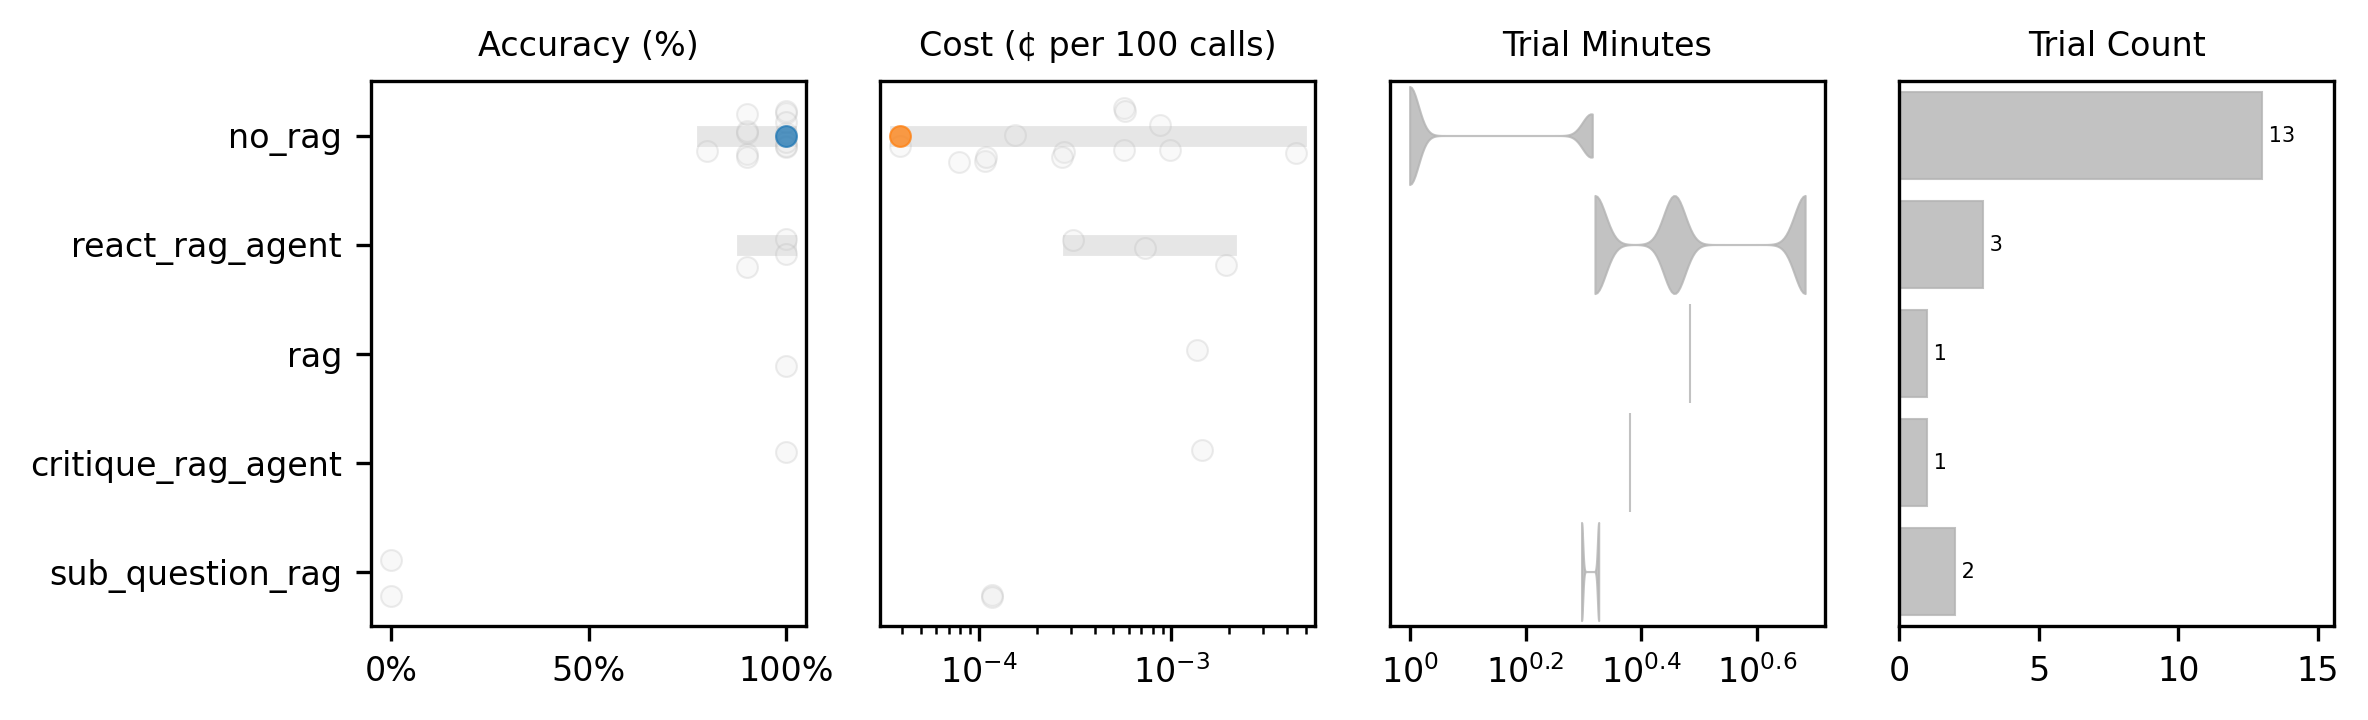

In [15]:
from syftr.plotting.insights import param_plot, safe_paretoset

# Calculate the 'pareto' column based on 'values_0' and 'values_1'
flows_df['pareto'] = safe_paretoset(flows_df[['values_0', 'values_1']], sense=['max', 'min'])

param_plot(
    flows_df,
    study_name="my-docs",
    param_cols=["params_rag_mode"]
)

## Metric Variability Across Identical Workflows

Displays the variability (standard deviation) of evaluation metrics such as accuracy and cost across repeated runs with identical parameter settings.

This helps identify which metrics are stable or sensitive to stochasticity in the RAG pipeline.

Running: plot_metric_variability
data has 20 rows


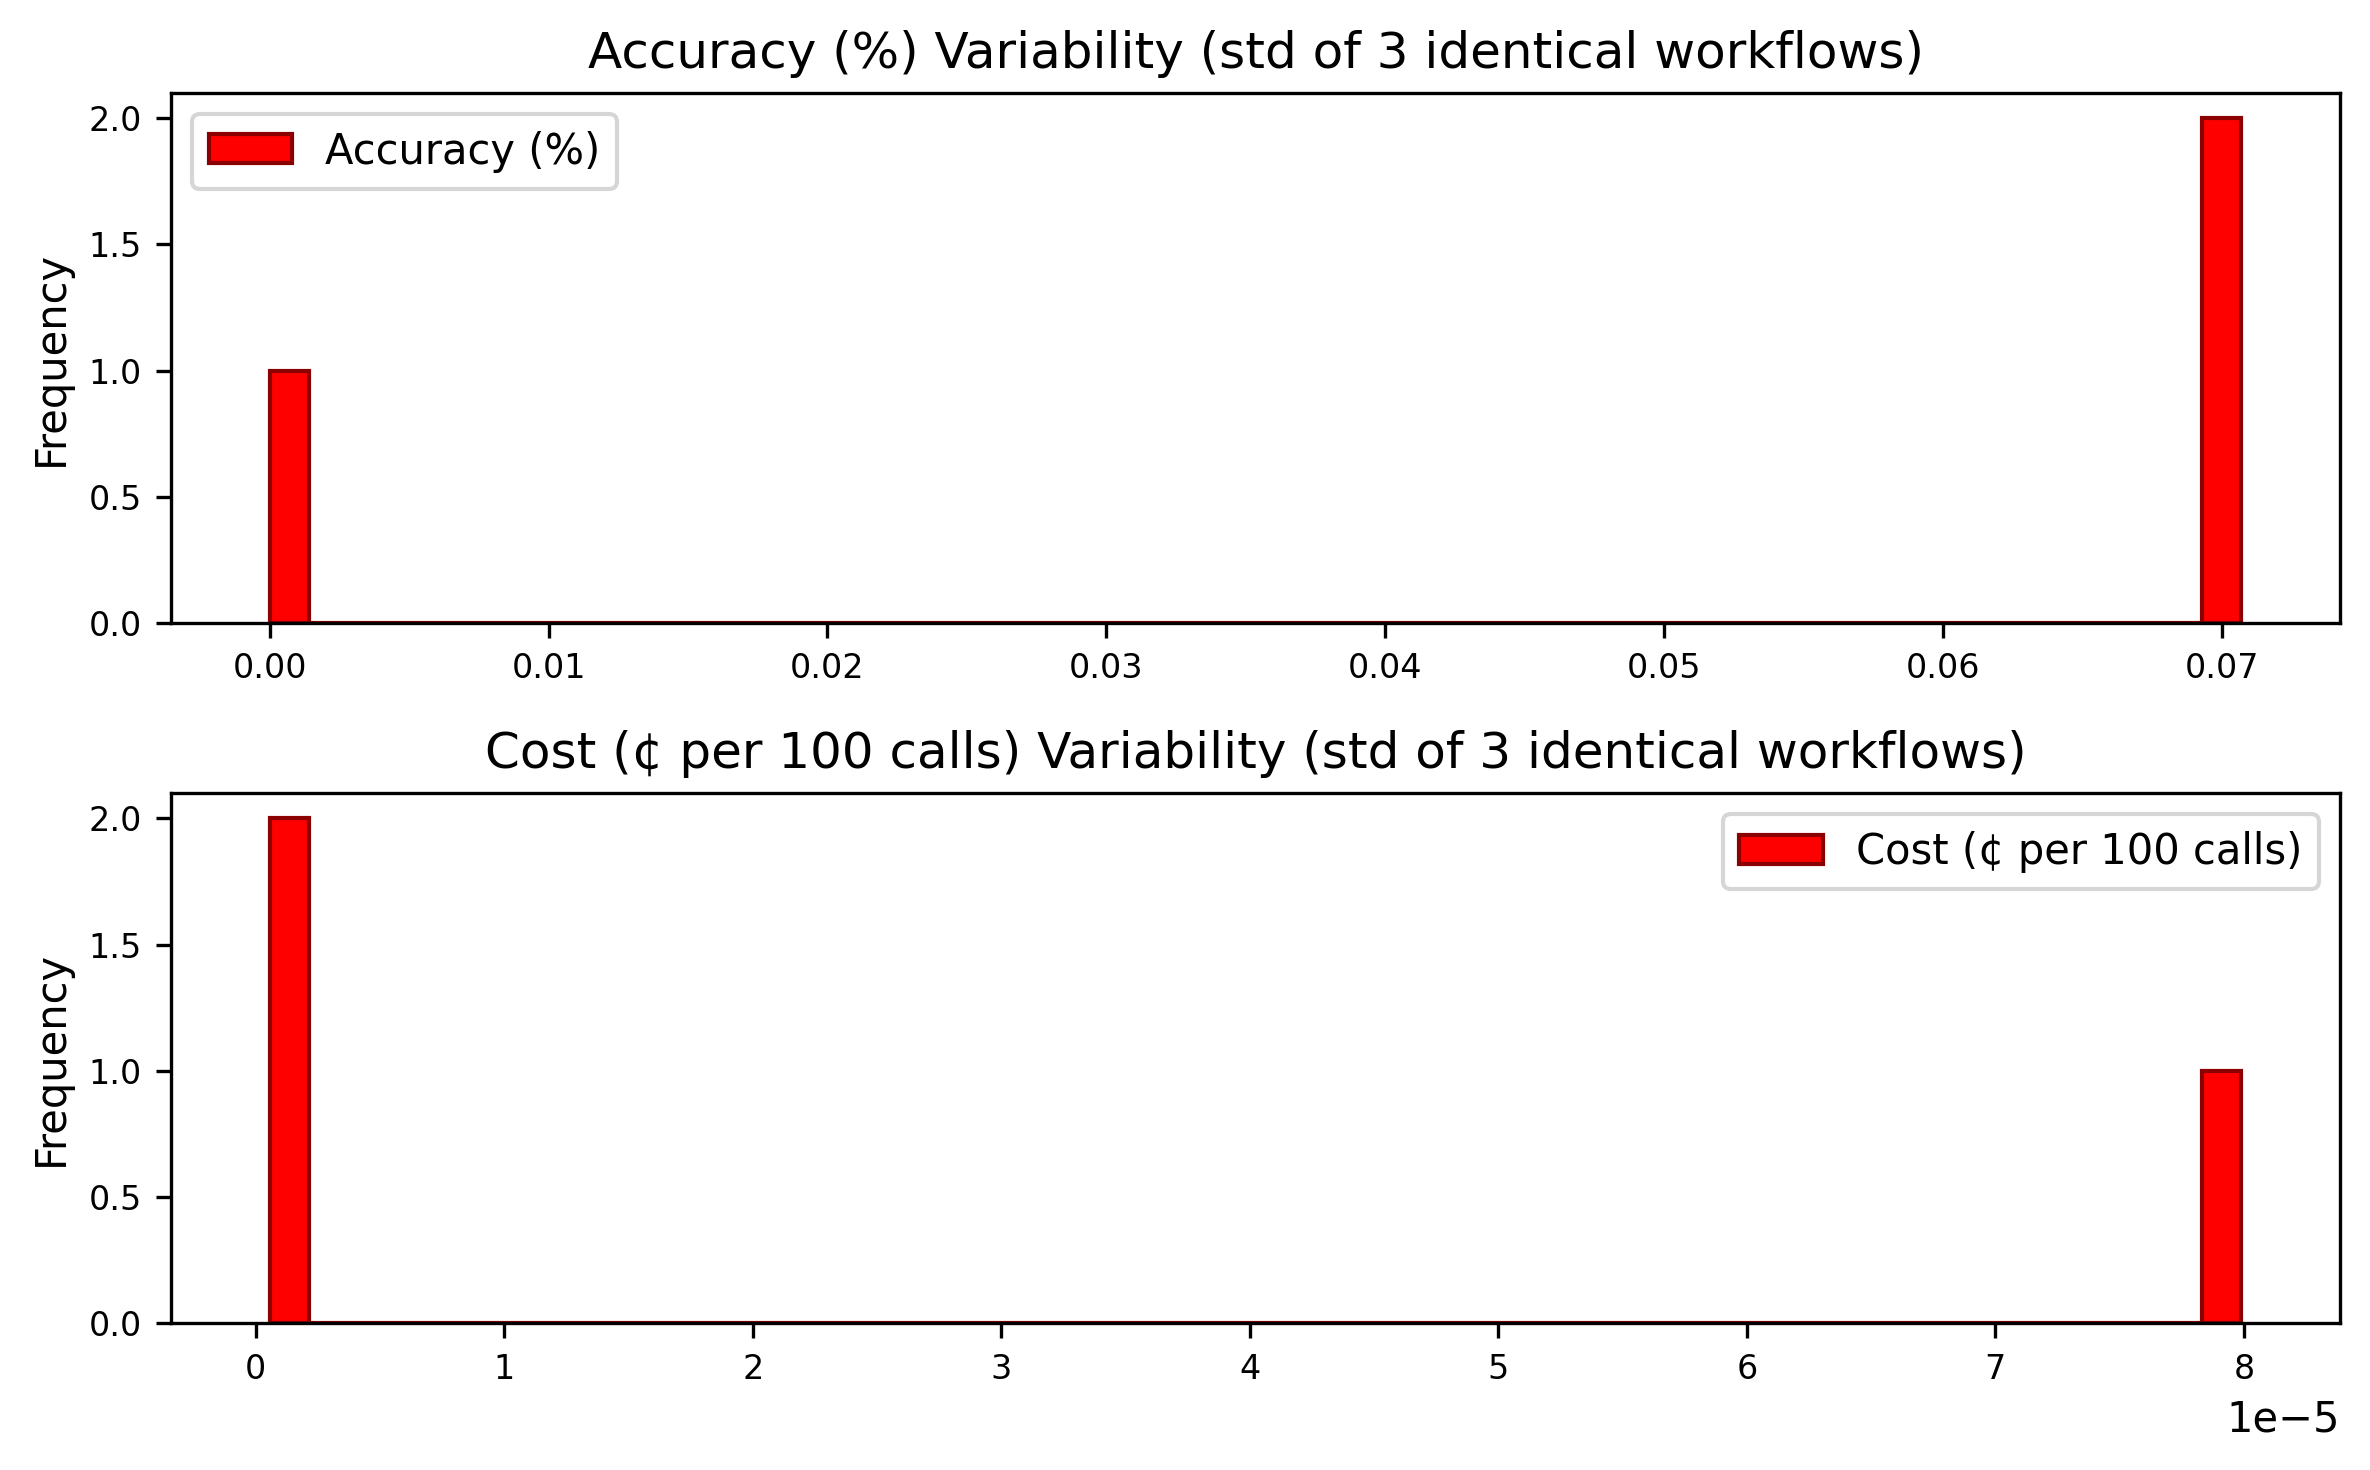

In [16]:
from syftr.plotting.insights import plot_metric_variability
_ = plot_metric_variability(flows_df, study_name="my-docs")

## Correlation with Accuracy

Computes Kendall correlations between all parameters/metrics and the target metric (accuracy) across flows.

- For numeric features with >3 unique values, a single correlation is computed.
- For categorical or low-cardinality features, each value is one-hot encoded and correlated separately.
- The 'Strength' column represents the average absolute correlation per parameter, weighted by sample count.

This analysis helps identify the most influential features affecting accuracy.


In [17]:
from IPython.display import display
from syftr.plotting.insights import what_correlates_with

non_dict_columns = [col for col in flows_df.columns
                    if not isinstance(flows_df[col].iloc[0], dict) and flows_df[col].nunique() > 1]

result = what_correlates_with(flows_df[non_dict_columns], flows_df["user_attrs_metric_accuracy"], method="kendall")
display(result.data)

Running: what_correlates_with


,,Correlation,Count,Strength
Parameter,Value,,,
values_0,*,1.0,20,1.000000
user_attrs_metric_accuracy,*,1.0,20,1.000000
user_attrs_metric_obj1_value,*,1.0,20,1.000000
rag_query_decomposition_num_queries,*,0.816497,3,0.816497
user_attrs_metric_llm_output_tokens_total_gpt-35-turbo,*,0.730297,6,0.730297
...,...,...,...,...
user_attrs_metric_llm_input_tokens_total_gpt-4o-mini,*,-0.023689,11,0.023689
user_attrs_metric_f1_score,*,0.006668,20,0.006668
user_attrs_metric_llm_cost_total_gpt-4o,*,0.0,6,0.000000


## Accuracy by Parameters Across Studies

Visualizes how combinations of key parameters (e.g., RAG mode and prompt template) influence accuracy and cost across multiple studies.

- Each row corresponds to a unique combination of parameter values.
- The left plots show normalized accuracy and cost for Pareto-optimal trials.
- "Frequency on Overall Pareto" shows how often each setting appears on the Pareto front.
- "Total Trial Count" indicates how many times the setting was evaluated across studies.

Useful for comparing performance tradeoffs across multiple experimental configurations.

Running: param_plot_all_studies
data has 20 rows


(<Figure size 2400x900 with 4 Axes>,
 'RAG Strategy x Prompt Template (Across 1 Studies)')

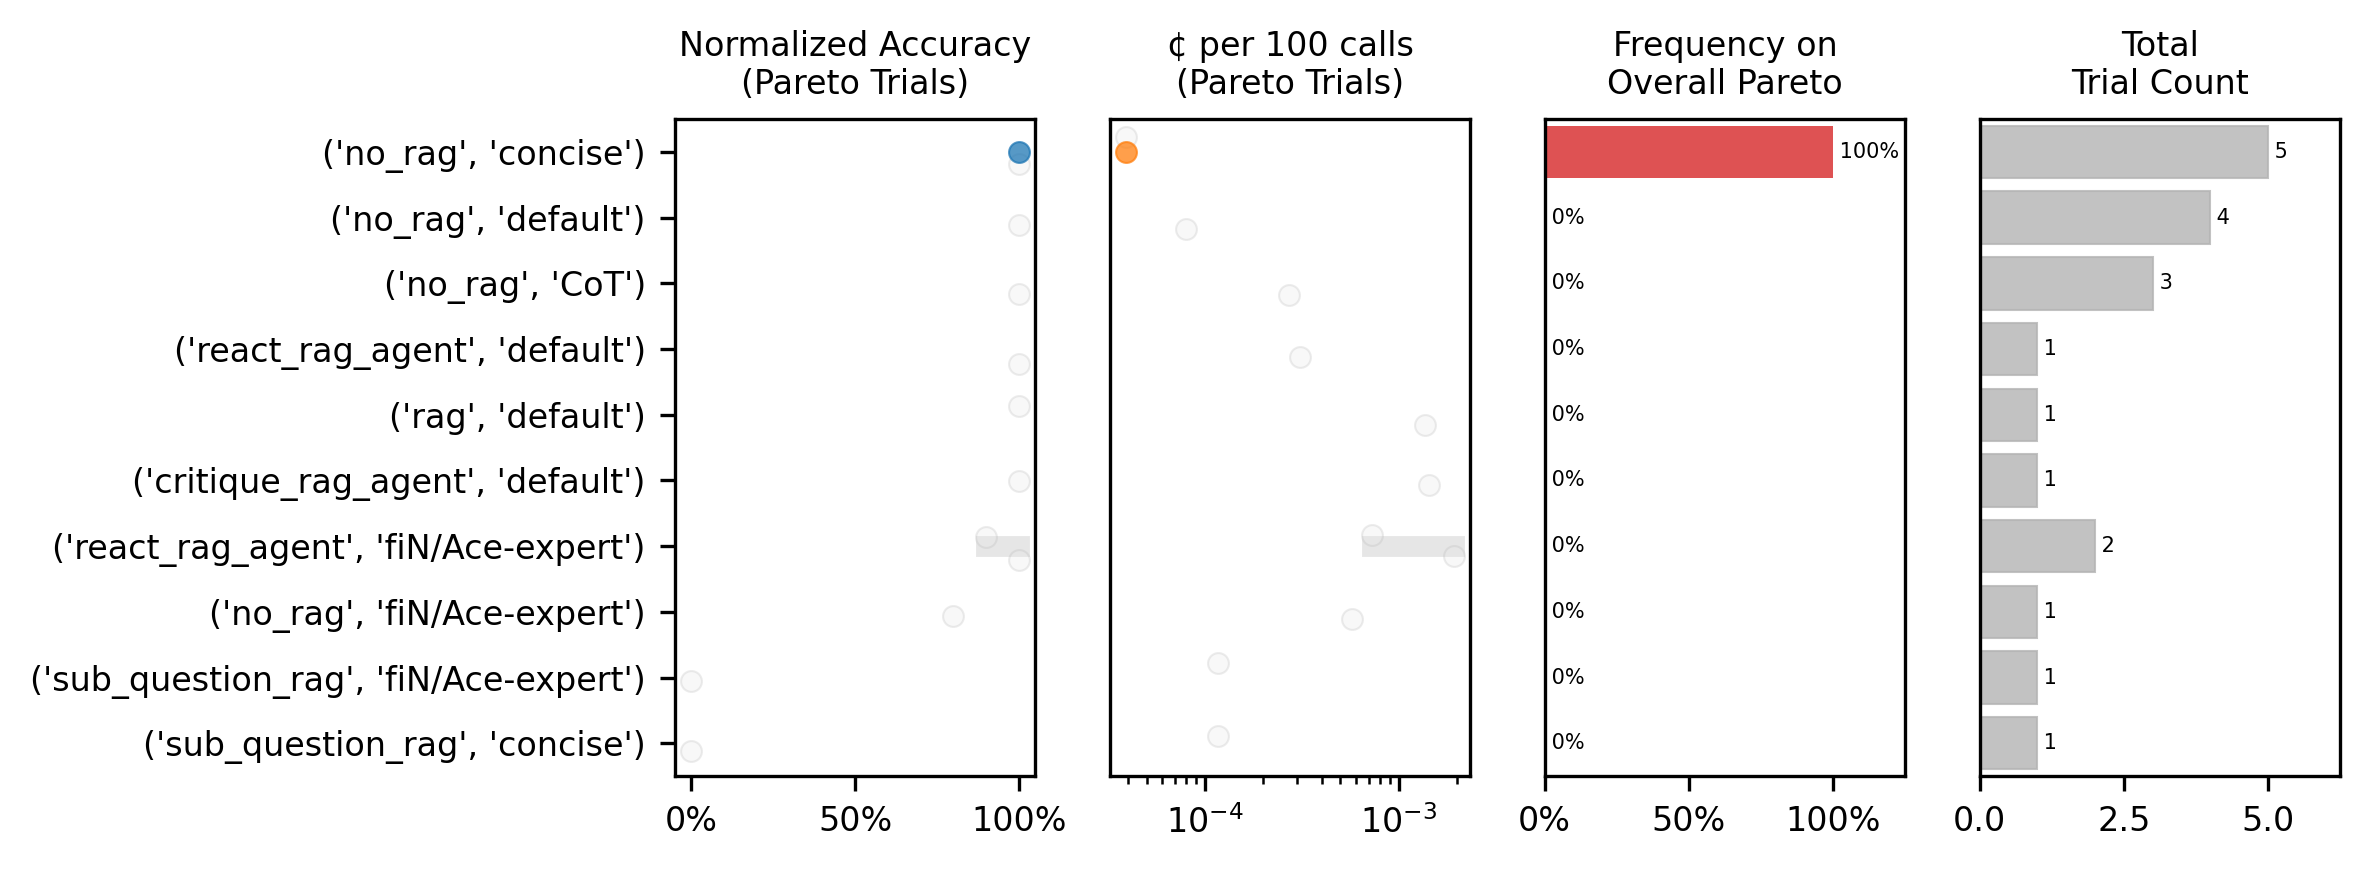

In [18]:
from syftr.plotting.insights import param_plot_all_studies
param_plot_all_studies(
    flows_df,
    study_name="my-docs",
    param_cols=["params_rag_mode", "params_template_name"]
)


In [19]:
flows_df.to_csv(cfg.paths.results_dir / "my-docs_flows.csv", index=False)